In [1]:
import os, sys, time

sys.path

import numpy as np

import matplotlib
# matplotlib.use('PDF')
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator

import emcee, corner
from multiprocessing import Pool
from multiprocessing import cpu_count

import pandas as pd
%matplotlib inline

#### Data explanation

In the data files, from first to last column: 

  1) offset in arcsec**, 
  
  2) intensity in Jy/beam, 
  
  3) error or stand dev* (same unit as intensity), 
  
  4) beam major axis (arcsec), 
  
  5) beam minor axis (arcsec).

# Define class and function

In [40]:
mksflux_to_Jy = 1e26
c_mks         = 299792458.0     # light speed in m/s
kB_mks        = 1.38064852e-23  # Boltzmann constant


def solidang_sr(maj_arcsec, min_arcsec):
    """
    
    Return solid angle in unit of Sr.
    
    Input :
    
    maj_arcsec, min_arcsec [float] : major/minor axis HPBW in units of arcseconds.
    
    
    Return :
        Omega_sr [float] : solid angle in units of Sr.
    
    """
    Omega_sr = np.pi \
                  * maj_arcsec * (np.pi / 180.0) / 3600.0 \
                  * min_arcsec * (np.pi / 180.0) / 3600.0
    Omega_sr =  Omega_sr / (  4.0 * np.log(2.0) )

    return Omega_sr


def brightnessT(flux_Jy, beamHPBWmaj_arcsec, beamHPBWmin_arcsec, freqGHz):
    '''
    Return brightness temperature.
    
    Inputs :
        flux_Jy [float] : flux density in units of Jy.
        beamHPBWmaj_arcsec, beamHPBWmin_arcsec [floats] : beam major/minor axes (FWHM), in units of arcsec
        freqGHz [float] : Observing frequency
    
    Return :
        Tb_Kelvin [float] : brightness temperture in unit of Kelvin.
    
    '''

    # beam solid angle
    Omega_sr = solidang_sr(beamHPBWmaj_arcsec, beamHPBWmin_arcsec)

    # flux unit conversion to MKS
    flux_mks = flux_Jy / mksflux_to_Jy

    # frequency unit conversion to Hz
    freqHz = freqGHz* 1e9

    # evaluate brightness temperature
    Tb_Kelvin = ( flux_mks / Omega_sr )  * \
          ( c_mks**2.0 /  (2.0 * kB_mks * (freqHz**2.0) ) )

    return Tb_Kelvin





class profilefit:
    '''
    A class to handle the profile fitting (using MCMC, which is powered by the emcee package).
    The fitting takes into consideration of Gaussian beam.
    
    An object of this class can be initialized by specifying a filename which is an ASCII file
    storing the offsets, intensity, and errors of intensity in the 0th, 1st, and 2nd columns, 
    respectively. If the filename is not given during the initialization,
    the file can also be loaded with the load_profile() function.
    It is assumed that the offsets are linearly and regularly spaced.
    
    Attributes:
        DataFrame [pandas data frame]   : created after loading the ASCII data file.
                                          It includes three columns: offset, intensity, intensity_err
        num_rows  [integer]             : number of rows in the input data
        sigma     [float]               : angular resolution in units of arcsecond.
        parms     [1d np array]         : Initial or bestfit parameters.
        parms_u, parms_l [1d np arrays] : +/- uncertainties of parms (created after fittings)
        
    
    Example:
    profilefit = profilefit()
    profilefit.load_profile(
                            filename = 'IRS63_b6_pa147.91_major.txt'
                           )
    '''
    
    def __init__(self, 
                 filename = ''):
        self.ifBrightness = False
        if (filename != ''):
            self.load_profile(filename = filename)
            
        self.if_mcmcSummarized = False
    
    def __del__(self):
        pass
    
    ########################################################################################
    #     Methods
    ########################################################################################
    
    def load_profile(self, filename = '', 
                     scale_x=1.0, scale_y=1.0, 
                     ifBrightness=False, 
                     bmaj=1.0, bmin=1.0, bpa=0.0, freqGHz=225.0,
                     slicepa=0.0,
                     xrange=[]
                    ):
        '''
        Loading input ASCII data file.
        
        Inputs:
            filanem [string] : Input filename.
            scale_x [float]  : A scaling fector for the offset values (e.g., to change units; default:1.0).
            scale_y [float]  : A scaling factor for the intensity values (e.g., to change units; default:1.0).
            ifBrightness [T/F] : True: convert input to brightness temperature. False: Not convert.

            bmaj/bmin [floats] : synthesized beam major and minor axes.
            bpa       [float]  : beam position angle [in unit of degree]
            freqGHz   [float]  : observing frequency.
            slicepa   [float]  : position angle of the slice
            xrange    [2-element list of floats] : Allow fitting data in a limited range
                                                   of x-variable. The display still shows
                                                   all data. The units are the same with
                                                   that of the offset. The absolute value
                                                   of x-offset is considered
        '''
        try:
            print('Loading file :', filename)
            
            # low data and obtain basic parameters
            self.DataFrame = pd.read_csv(filename, sep=' ', usecols = [0, 1, 2],
                                         header=None, names=["offset", "intensity", "intensity_err"])
            self.num_rows = np.size(self.DataFrame.intensity)
            self.ifBrightness = ifBrightness
                        
            # using the following code to avoid offset = 0.0 #####################
            elements = np.where(self.DataFrame.offset == 0.0
                               )
            elements = np.array(elements[0])
            self.DataFrame.offset[elements] = 1e-15
            ######################################################################
            
            ### Give zero uncertainties with some values #########################
            # this part is very unhealthy. Should fix the measurement
            self.DataFrame.intensity_err = self.DataFrame.intensity_err
            elements = np.where(self.DataFrame.intensity_err == 0.0
                               )
            elements = np.array(elements[0])
            self.DataFrame.intensity_err[elements] = \
               self.DataFrame.intensity_err[elements] + 0.00001
            ######################################################################
  
            # rescale units
            self.DataFrame.offset    = self.DataFrame.offset * scale_x
            if self.ifBrightness == False:
                self.DataFrame.intensity = self.DataFrame.intensity * scale_y
                self.DataFrame.intensity_err = self.DataFrame.intensity_err * scale_y
            else:
                self.DataFrame.intensity = brightnessT(
                                            self.DataFrame.intensity, 
                                            bmaj, bmin, freqGHz
                                                      )
                self.DataFrame.intensity_err = brightnessT(
                                            self.DataFrame.intensity_err, 
                                            bmaj, bmin, freqGHz
                                                          )
                
            # Set the range of x-variable for data fitting
            if len(xrange) == 0:
                self.xrange = [-1e-6, 1e20]
            else:
                self.xrange = xrange
                
            # evaluate the angular resolution in the direction of the slice
            self.sigma = self.get_sigma(bmaj, bmin, bpa, slicepa)
                        
        except:
            print('Error loading profile data. Please double check the path or the content in the file.')
            

    def get_sigma(self, bmaj, bmin, bpa, slicepa):
        '''
        Return the angular resolution in the direction of the slice.
        
        '''
        diff_pa = slicepa - bpa
        diff_pa = diff_pa * (np.pi / 180.0)
        sigma   = np.sqrt(
                          (bmaj * np.cos(diff_pa) )**2.0 +
                          (bmin * np.sin(diff_pa) )**2.0
                         )
        
        return sigma
    
            
    def initialize_mcmc(self, model_func, lnprior_func, nwalkers=1, init_parms=[]):
        '''
        Fit a power-law profile and return the best-fit power-law index.
        
        Input:
            model_func [function]     : A function to evaluate models.
                                        It takes two inputs: (1) x-variable, (2) model-parameters
            nwalkers   [int]          : Number of mcmc walkers (default: 1)
            init_parms [float list]   : An initial guess for parameters (default: [])
        '''
        self.nwalkers          = nwalkers
        self.parms             = np.array(init_parms)
        
        self.get_initial_pos()
        
        self.get_model    = model_func
        self.lnprior_func = lnprior_func
        
        self.args = [
                     np.array(test.DataFrame.offset), 
                     np.array(test.DataFrame.intensity), 
                     np.array(test.DataFrame.intensity_err)
                    ]

        self.args.extend( [model_func, lnprior_func] )
        self.args = tuple( self.args )

    
    
    def get_initial_pos(self):
        '''
        Obtain initial positions for the MCMC samplers.
        Tentatively use the initial guess + the normal distributions that the width are 0.5 times the
        initial guess
        '''
        self.initial_pos = [
                self.parms  + 
                self.parms  * 0.5 * np.random.randn( len(self.parms) )
               for i in range(self.nwalkers)
              ]
        
            
    def summarize_mcmc(self, samples, step_to_discard=0):
        '''
        Make a summary of the MCMC result and update self.parms, self.parms_u, self.parms_l
        
        Input:
            samples [emcee sample structure] : N/A
            step_to_discard [int] : Allow discarding first some steps (i.e., burn-in steps.)
        '''
        self.samples = samples.chain[:, step_to_discard:, :].reshape((-1, len(self.parms) ))
        self.step_to_discard = step_to_discard
        
        num_samples  = len(self.samples)
        num_parms    = len(self.parms)
        
        self.parms_u = np.zeros(num_parms)
        self.parms_l = np.zeros(num_parms)
        
        for i in range(0, num_parms):
            self.parms[i]   = np.array( *np.percentile(self.samples, [50], axis=0) )[ i ]
            self.parms_u[i] = np.array( *np.percentile(self.samples, [84], axis=0) )[ i ]
            self.parms_l[i] = np.array( *np.percentile(self.samples, [16], axis=0) )[ i ]
            
        self.if_mcmcSummarized = True
    
    
    def output_samples(self, outname='temp_mcmc_samples.txt'):
        '''
        Output the samplers to a ASCII file.
        '''
        
        # sanity check        
        if self.if_mcmcSummarized == False:
            print('output_samples Error. Please run summarize_mcmc first')
            return
            
        outsample    = open(outname, "w" )
        num_parms    = len(self.parms)

        try:
            for i in range( len(self.samples) ):
                temp = ''
                for model_parm_id in range(0, num_parms):
                    temp += str( self.samples[i][model_parm_id] ) + ' '
                temp += '\n'
                outsample.write( temp )
        except:
            print('Error outputing files')
                
        outsample.close()

    
    
    def make_corner(self, sample_name='', 
                        bins = 64,
                        labels = [],
                        plot_contours = False,
                        show_titles   = True,
                        quantiles     = [],
                        plot_datapoints = True,
                        outfigname='temp_mcmc_cornor.pdf',
                        levels = [0.68,0.95,0.997],
                        color  = (0, 0, 0, 1),
                        datapoint_color = (0, 0, 0, 1),
                        datapoint_alpha = 0.01,
                        markersize = 0.1,
                        plot_range = []
                   ):
        '''
        Produce a corner plot.
        
        Input:
          sample_name [string]: A filename (ASCII) to read samples to plot.
                                Default is '', which will not read from input file, instead
                                will plot self.samples.
          plot_range [list of two-element lists] : The size of this list has to be identical to the
                                                   number of input parameters. This allows specifying
                                                   the plotting range for individual parameters.
        ''' 
        
        print ( 'Start making corner plot' + time.asctime( time.localtime(time.time()) ) )
        if (len(labels)>0):
            outlabels  = labels
        else:
            labels = []
            for i in range( len(self.parms) ):

                labels.extend( ' ' )
            outlabels = list(labels)

        # sanity check        
        if self.if_mcmcSummarized == False:
            print('make_corner Error. Please run summarize_mcmc first')
            return               
            
        bins_array = []
        for i in range(0, len(self.parms)  ):
            bins_array.append(bins)

        if plot_range == []:
            fig = corner.corner(self.samples,
                            labels = outlabels,
                            truths = np.array(self.parms),
                            plot_contours = plot_contours,
                            bins = bins_array,
                            show_titles = show_titles, quantiles = quantiles,
                            plot_datapoints = plot_datapoints,
#                            levels = levels,
                            color = color,
                            data_kwargs = {'ms': markersize, 'color': datapoint_color}
                           )
        else:
            fig = corner.corner(self.samples,
                            labels = outlabels,
                            truths = np.array(self.parms),
                            plot_contours = plot_contours,
                            bins = bins_array,
                            show_titles = show_titles, quantiles = quantiles,
                            plot_datapoints = plot_datapoints,
#                            levels = levels,
                            color = color,
                            data_kwargs = {'ms': markersize, 'color': datapoint_color},
                            range = plot_range
                           )            

        fig.savefig(outfigname)
        print ( 'Finished making corner plot' + time.asctime( time.localtime(time.time()) ) )

        
    def plot_sampler(self, sampler, 
                     outfigname='temp_samplers.pdf',
                     figsize=[10,6], 
                     labels = [],
                         label_fontsize=14,
                     x_label_fontsize=14, y_label_fontsize=14,
                     plot_range = []
                    ):
        '''
        Plot how the samplers vary with MCMC step number.
        
        Input:
            sampler [emcee sampler object] :
            outfigname      [str]          : Name of the output figure.
            figsize: normal matplotlib parameters.
            label           [str]       : A label inside the panel.
            label_fontsize  [float]     : fontsize for the label.
            x, y_label_fontsize=14 [float] : fontsizes of the x and y labels.
            plot_range [list of two-element lists] : The size of this list has to be identical to the
                                                     number of input parameters. This allows specifying
                                                     the plotting range for individual parameters.
        
        '''        
        # sanity check        
        if self.if_mcmcSummarized == False:
            print('plot_sampler Error. Please run summarize_mcmc first')
            return
        
        num_parms   = len(self.parms)
        fig, axes   = plt.subplots(num_parms, figsize=figsize, sharex=True)
        
        samples = sampler.get_chain()
        num_samples = len(samples)
        
        if (len(labels)>0):
            outlabels  = labels
        else:
            labels = []
            for i in range( len(self.parms) ):
                labels.extend( ' ' )
            outlabels = list(labels)        
        
        for i in range(0, num_parms):
            ax = axes[i]
            ax.plot(samples[:, :, i], "k", alpha=0.3)
            ax.set_xlim(self.step_to_discard, num_samples)
            if plot_range != []:
                ax.set_ylim(plot_range[i][0], plot_range[i][1])
            ax.set_ylabel(outlabels[i], fontsize=y_label_fontsize)
            # ax.yaxis.set_label_coords(-0.1, 0.5)

        axes[-1].set_xlabel("step number", fontsize=x_label_fontsize)
        plt.show()
        plt.savefig(outfigname)  
        
    
    def plot_profile(self, outfigname='temp_profile.pdf', 
                label='None', 
                     label_fontsize=14,
                tick_fontsize=14,
                x_label='Offset', y_label='Intensity',
                     x_label_fontsize=14, y_label_fontsize=14,
                data_color=(0.2,0.2,0.2,1), elinewidth=1.0,
                xlim=[], ylim=[], 
                xscale='linear', yscale='linear',
                figsize=[10,6], plot_range=[0.14, 0.1, 0.85, 0.85],
                plot_model=True,
                    model_color=(1,0,0,0.5), model_linewidth=2.0):
        '''
        Plot the loaded ASCII data files (and the fitted profile, if exist).
        
        Inputs:
            outfigname      [str]       : Name of the output figure.
            label           [str]       : A label inside the panel.
            label_fontsize  [float]     : fontsize for the label.
            tick_fontsize   [float]     : fontsize for the ticks. 
            x_label, y_label  [str]        : Labels for the x and y axes.
            x, y_label_fontsize=14 [float] : fontsizes of the x and y labels.
            data_color                  : (R,G,B) color for the data.
            elinewidth      [float]     : linewidth for the errorbar.
            xlim, ylim  [list of float] : X and y ranges for plotting
            figsize, plot_range, xlim, ylim, xscale, yscale : normal matplotlib parameters.
            plot_model      [True/False] : If true, plot the model. If there is a final mcmc result,
                                           plot it; otherwise, plot the initial guess.
            model_color                 : (R,G,B, alpha) in matplotlib syntax. Default: (1,0,0,0.5)
            model_linewidth [float]     : default: 2.0
        '''
        fig = plt.figure(figsize=figsize)
        ax = fig.add_axes(plot_range)
        
        # plot model
        if plot_model == True:
            #try:
                # evaluate model
                model = self.get_model(
                                       np.array(self.DataFrame.offset),
                                       self.parms
                                      )                
                # Smooth model to the observed resolution
                model = self.gaussian_convolve(model, np.array(self.DataFrame.offset), self.sigma)
                plt.plot(self.DataFrame.offset, model,
                       color=model_color, linewidth=model_linewidth )
            #except:
            #    pass
        
        # plot error-bar
        ax.errorbar(self.DataFrame.offset, self.DataFrame.intensity, 
                    yerr=self.DataFrame.intensity_err, 
                    color=data_color, 
                    ecolor=data_color, elinewidth=elinewidth)
        
        plt.tick_params(labelsize=tick_fontsize)
        plt.xlabel(x_label, fontsize=x_label_fontsize)
        plt.ylabel(y_label, fontsize=y_label_fontsize)
        plt.xscale(xscale)
        plt.yscale(yscale)
        
        if (label != 'None'):
            ax.text(0.02, 0.92, label, transform=ax.transAxes,
                     color=(0,0,0,1),
                     fontsize=label_fontsize, horizontalalignment='left')
        
        plt.show()
        plt.savefig(outfigname)       
            
    ########################################################################################
    #     Internal function
    ########################################################################################

    def gaussian_1d(self, x, x0, sigma):
        '''
        Return a Gaussian distribution that is normalized to 1.0
                
        Input:
            x [1d np array] : offset
            x0 [float]      : central position of the Gaussian
            sigma [float]   : standard deviation of the Gaussian
            
        Return:
            [1d np array]   : A 1-dim Gaussian function that has the same size as the x array.
        '''
        A = 1.0 / (sigma * np.sqrt(2.0 * np.pi))
        B = -0.5 * (( (x - x0)/sigma )**2.0)
        
        return A * np.exp(B)    
    
    
    def gaussian_convolve(self, function, x, sigma):
        '''
        Return a convolution of function with a 1d gaussian that has sigma standard deviation.
        
        Input:
            function [1d np array] : A 1-dim function to be convolved with a Gaussian;
                                     this function is a function of offset x.
            x [1d np array]        : offset
            sigma [float]          : standard deviation of the Gaussian.
        
        Return:
            [1d np array] : The 1-dim Gaussian-smoothed input function
        '''
        num_ele      = np.size(function)
        out_function = np.zeros(num_ele)
        delta_x      = np.absolute( x[1] - x[0] )
        
        for i in range(0, num_ele):
            x0 = x[i]
            out_function += function[i] * self.gaussian_1d(x, x0, sigma) * delta_x
        
        return out_function    
    
    
    def lnprob(self, parms, x, y, yerr, 
               model_func, 
               lnprior_func
              ):
        '''
        Return the logged probability
            
        
        Input:
            parms [1d np array] : model parameters: [A0, r0, index]
            sigma [float]   : standard deviation of the Gaussian that is used to smooth the power-law
        '''
        

        # evaluate prior probability distribution
        lp = lnprior_func(parms)
        if not np.isfinite(lp):
            return -np.inf        
        
        
        # initialize probability
        temp_prob = 0.0 + lp
    
        
        # evalute model profile
        model = self.get_model(x, parms)
    
        # smooth the model
        model = self.gaussian_convolve(model, x, self.sigma)
        model = np.array(model)
        
        # evaluate log probability
        '''
        index     = np.where( yerr > 0 )
        index     = np.array( index[0] )
        
        y         = np.array( y )
        yerr      = np.array( yerr )
        '''
        index = np.where(
                          ( 
                            (x > self.xrange[0]) &
                            (x < self.xrange[1]) 
                          )
                          |
                          ( 
                            (x < -self.xrange[0]) &
                            (x > -self.xrange[1]) )
                          )
        temp_prob += -0.5 * (
                             np.sum(
                                    ( ( y[index] - model[index] )**2 ) /
                                    ( yerr[index]**2 )
                                   )
                            )
        
        return temp_prob
    

In [41]:
def powerlaw(x, parms):
    '''
    create a power-law that is A0 * ( (r/r0)**index )
        
    Input:
        x [1d np array] : offset
        parms [list of float]  : [A0, r0, pindex]
                                 0th element: value at the specific x-variable r0
                                 1th element: the reference x-variable r0
                                 2nd element: power-law index
                                 
        A0      [float] : the value of the power law at the location r=r0
        r0      [float] : a reference location.
        pindex   [float] : power-law index
        
    Return:
        [1d np array] : A 1-dim power-law that has the same size as the x array.
    '''
    A0     = parms[0]
    r0     = parms[1]
    pindex = parms[2]
    model = parms[0] * ( (np.absolute(x) / parms[1] )**parms[2] )

    # Set an upper limit of dust temperature to 1500 K
    index = np.where( np.isfinite(model) == False )
    if ( np.size(index)>0 ):
        model[index] = 1500.0
    index = np.where( model > 1500.0 )
    if ( np.size(index)>0 ):
        model[index] = 1500.0
        
    return model
    
    
def lnprior(parms):
    '''
    Prior function.
    '''
    if parms[1] < 0:
        return -np.inf
    
    return 0

######## Processing ../../cuts_profiles/IRS63_b6_pa147.91_major.txt##########
Loading file : ../../cuts_profiles/IRS63_b6_pa147.91_major.txt
Loading file : ../../cuts_profiles/IRS63_b6_pa147.91_major.txt
You have 8 CPUs
########### Starting running MCMC ########### Sun Aug 28 12:24:49 2022


100%|███████████████████████████████████████████████████| 50/50 [00:03<00:00, 15.08it/s]


########### Finished running MCMC ########### Sun Aug 28 12:24:53 2022


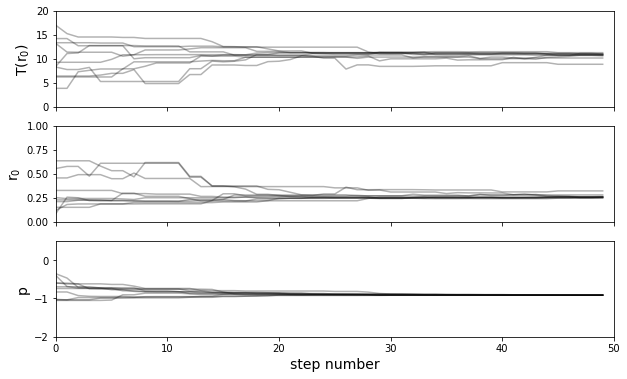

<Figure size 432x288 with 0 Axes>

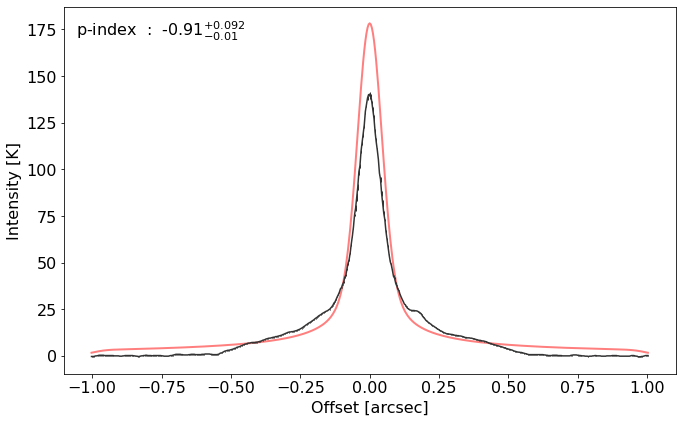

Start making corner plotSun Aug 28 12:24:53 2022
Finished making corner plotSun Aug 28 12:24:54 2022


<Figure size 432x288 with 0 Axes>

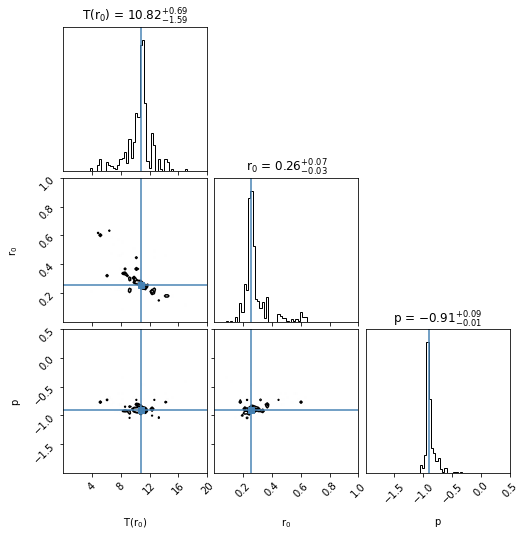

In [45]:
# Data setup
path     = '../../cuts_profiles/'
filename = 'IRS63_b6_pa147.91_major.txt'

# model setup
init_parms   = [10.0, 0.3, -0.75]
model_func   = powerlaw
lnprior_func = lnprior

# MCMC setup
nwalkers        = 10   # need to be a few times larger than the number of free-parameters
nsteps          = 50
n_processor     = 1
step_to_discard = 0

# Flow Control
if_plotSampler   = True
if_outputSamples = False
if_MakeCorner    = True



##### Fitting process #######################################################################################
print('######## Processing ' + path + filename + '##########')

test = profilefit()

# Obtain the angular resolution in the direction of the slice
test.load_profile(filename = path + filename,
                  bmaj=0.04063, bmin=0.03567, bpa=0.0, freqGHz=225.0,
                 )
xrange = [0.5*(test.sigma/2.35), 1e10]

# re-load data
test.load_profile(filename = path + filename,
                  bmaj=0.04063, bmin=0.03567, bpa=0.0, freqGHz=225.0,
                  ifBrightness=True, xrange = xrange
                 )

# initialize MCMC fittings
test.initialize_mcmc(
                     model_func, lnprior_func, 
                     nwalkers    = nwalkers, 
                     init_parms  = init_parms,  # initial model parameters
                    )

##### Initialize MCMC #######################################################################################
ncpu = cpu_count()
print("You have {0} CPUs".format(ncpu))

if (n_processor < ncpu):
    # Setup multi-processor
    pool = Pool(processes = n_processor)
    
    # Construct emcee sampler
    sampler = emcee.EnsembleSampler(
                                    test.nwalkers,     # number of walkers
                                    len( test.parms ), # number of free-parameters
                                    test.lnprob,       # function to evaluate log probability
                                    args = test.args,
                                    # pool = pool        # Multi-processor
                                   )

if (n_processor < ncpu):
    
##### Runnning MCMC ########################################################################################
    print (  '########### Starting running MCMC ###########', time.asctime( time.localtime(time.time()) ) )
    sampler.run_mcmc( test.initial_pos, nsteps, progress=True)
    print (  '########### Finished running MCMC ###########',  time.asctime( time.localtime(time.time()) ) )

    
##### Summarize the results ################################################################################
if (n_processor < ncpu):

    test.summarize_mcmc(sampler, step_to_discard=step_to_discard)
    
    # Plot the variation of sampler values as steps
    if if_plotSampler == True:
        test.plot_sampler(sampler, 
                          labels = ['T(r$_{0}$)','r$_{0}$','p'],
                          plot_range = [
                                        (0, 20.0),
                                        (0, 1.0),
                                        (-2.0,0.5)
                                       ]
                         )
    
    # Plot the data and the fitted profile
    label_string = 'p-index  :  ' + str( format(test.parms[2], '.2g')    )  + r'$' \
                              + r'^{+' + str(  format(test.parms_u[2] - test.parms[2], '.2g')  ) + r'}' \
                              + r'_{-' + str(  format(test.parms[2] - test.parms_l[2], '.2g')  ) + r'}' \
                              + r'$'    
    test.plot_profile(
                  # xscale='log', yscale='log',
                  label = label_string, label_fontsize=16, 
                  x_label='Offset [arcsec]', y_label='Intensity [K]',
                  x_label_fontsize=16, y_label_fontsize=16,
                  tick_fontsize=16,
                 )
    
    # Output all samplers to a ASCII file
    if if_outputSamples == True:
        test.output_samples()
    
    # Making corner plot (extremely time consuming)
    if if_MakeCorner == True:
        test.make_corner(
                         plot_contours = True,
                         labels = ['T(r$_{0}$)','r$_{0}$','p'],
                         plot_range = [
                                       (0, 20.0),
                                       (0, 1.0),
                                       (-2.0,0.5)
                                      ]
                        )
